# A Fully-Connected Network with Binarized Weights, 2-bit Activations

This section will be a small increment of what we did in the previous one. We'll take a network that is almost exactly the same as the previous one, with one difference: it will be using 2-bit activations instead of binarized ones.

What is the advantage of using 2-bit activations, you may wonder? Usually, the more bits of precision you use, the more accurate your QNN classification results you will get. For instance, if we apply the previous network on the 1000 first images from the MNIST test set, it will make 44 misclassifications, whereas the one with 2-bit activations will make 33 misclassifications. 

We will start by loading the new network and our previous test image with a digit 7 again:

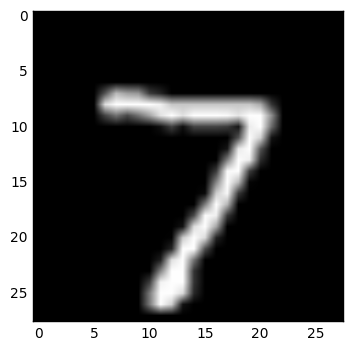

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# load image using PIL
img = Image.open("7.png")
# convert to black and white
img = img.convert("L")
# convert to numpy array
img = np.asarray(img)
# display
% matplotlib inline
plt.imshow(img, cmap='gray')

from QNN.layers import *
import pickle
# load the qnn
qnn = pickle.load(open("mnist-w1a2.pickle", "rb"))
qnn

## Thresholding for 2-bit Activations

As you can see, there are exactly as many layers as there were in the previous one and the layer names are almost the same, with one exception: here we have QNNThresholdingLayer instead of QNNBipolarThresholdingLayer, since we now have 2-bit activations. This means each output element from the thresholding layer can have four different values: 0, 1, 2 or 3. 

Let's start by examining one of those thresholding layers to see what the parameters look like:

In [20]:
print("Threshold parameter shape: " + str(qnn[2].thresholds.shape))
print("Thresholds for the first vector element: " + str(qnn[2].thresholds[:, 0]))
print("Thresholds for the second vector element: " + str(qnn[2].thresholds[:, 1]))

Threshold parameter shape: (3, 256)
Thresholds for the first vector element: [ 5 49 78]
Thresholds for the second vector element: [-23  25  58]


Recall that the **thresholds** parameter of the QNNThresholdingLayer has two dimensions: the first dimension is the particular "stair step" location, and the second dimension is the particular input vector index that this threshold will be applied to. A few things worth pointing out about these thresholds:
1. Thresholds can be totally different for different input vector elements. Here we can see that the thresholds for the second input vector element are lower than the thresholds for the first one. We will be generalizing this to *channels* in the next section for convolutional neural networks.
2. Since we want four different values coming out of the thresholding function, we have three steps. In general, if you want to divide a space into N regions, you will need N-1 separators.
3. Notice how the threshold values are always larger for the next step, but the difference between consecutive steps is not always the same. For instance, the thresholds for the first vector element have differences of 49-5=44, and then 78-49=29.

Let's plot the threshold function for the first vector element to understand this a little better:

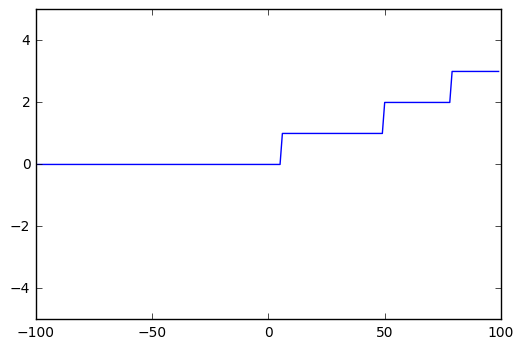

In [21]:
def simpleThreshold(x):
    if x <= 5:
        return 0
    elif x <= 49:
        return 1
    elif x <= 78:
        return 2
    else:
        return 3

x = range(-100,100)
y = map(simpleThreshold, x)
plt.plot(x, y)
plt.ylim([-5, 5])
plt.show()

You can see how the returned value goes from 0 to 3 as the input value increases, mapping any real number to one of its "stair steps". Notice that we can represent any of the values returned by this particular function using two bits: 0 is 00, 1 is 01, 2 is 10 and 3 is 11 in binary, so this is actually a two-bit [quantizer](https://en.wikipedia.org/wiki/Quantization_(signal_processing)). 

Let's look at one of the activations produced by our network to see this in action:

In [22]:
qnn[0].execute(img)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       3, 3,

There we go -- the activation only contains the values 0, 1, 2 and 3. Just to make sure this network actually works, let's run it all the way through:

In [23]:
# get the predictions array
res = predict(qnn, img)
# return the index of the largest prediction
winner_ind = np.argmax(res)
# the sum of the output values add up to 1 due to softmax,
# so we can interpret them as probabilities
winner_prob = 100 * res[winner_ind]
print(res)
print("The QNN predicts this is a %d with %f percent probability" % (winner_ind, winner_prob))

[  1.83423800e-04   2.80956471e-04   1.83361667e-03   8.53998803e-04
   1.80900855e-04   4.23054777e-04   6.18959071e-05   9.95056417e-01
   9.90050351e-05   1.02673042e-03]
The QNN predicts this is a 7 with 99.505642 percent probability


We won't look at this network in any more details, since everything else is almost exactly the same as the previous one. You can look inside the weights for the fully-connected layers, which will still consist of -1 and +1s, so we don't have to use the same quantization for the weights and activations. In fact, the particular quantization we use can potentially be different in each layer! The "magic numbers" may have changed, but the computation is the same.

In the next section, we will start looking at more complicated (e.g. convolutional) network topologies, and apply them to datasets slightly more exciting than black-and-white handwritten digits.